Churn Analysis with Pyspark

This tutorial is created on the databricks cloud. It presents six classifiers that will be compared at the cross validation part. I will explain how to compute the different evaluate metrics on the binary classification case.
Churn prediction is big business. It minimizes customer defection by predicting which customers are likely to cancel a subscription to a service. Though originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals.
The prediction process is heavily data driven and often utilizes advanced machine learning techniques. In this post, we will take a look at what types of customer data are typically used, do some preliminary analysis of the data, and generate churn prediction models - all with PySpark and its machine learning frameworks.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
sns.set_style("darkgrid")
import pyspark

In [0]:
# Initializing a Spark session

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()

Importing Churn Data
We will be using the Orange Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. The two sets are from the same batch but have been split by an 80/20 ratio. We will use the larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation.
In order to read the CSV data and parse it into Spark Data Frames, we will use the CSV package.

In [0]:
df = spark.read.csv('/FileStore/tables/churn_bigml_80-7.csv', header='true', inferSchema='true')

testdf = spark.read.csv('/FileStore/tables/churn_bigml_20-4.csv', header='true', inferSchema='true')

df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [0]:
df.describe().show()

+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+----------------------+
|summary|State|    Account length|         Area code|International plan|Voice mail plan|Number vmail messages| Total day minutes|   Total day calls|  Total day charge| Total eve minutes|   Total eve calls|  Total eve charge|Total night minutes| Total night calls|Total night charge|Total intl minutes|  Total intl calls| Total intl charge|Customer service calls|
+-------+-----+------------------+------------------+------------------+---------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------

In [0]:
print("The training dataset contains {} samples.".format(df.count()))
print("The test dataset contains {} samples.".format(testdf.count()))

The training dataset contains 2666 samples.
The test dataset contains 667 samples.


In [0]:
#Generating a Pandas Dataframe with df, we can get a display of what the rows look like. We are using Pandas instead of the Spark DataFrame.show() function because it creates a clear picture of the dataframe.

In [0]:
df.select("*").toPandas().head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [0]:
df.select("*").toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int32  
 2   Area code               2666 non-null   int32  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int32  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int32  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int32  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int32  
 14  Total night charge      2666 non-null   

In [0]:
# Summary Statistics
df.select("*").toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Account length,2666.0,100.620405,39.563974,1.00,73.0000,100.00,127.000,243.00
Area code,2666.0,437.438860,42.521018,408.00,408.0000,415.00,510.000,510.00
Number vmail messages,2666.0,8.021755,13.612277,0.00,0.0000,0.00,19.000,50.00
Total day minutes,2666.0,179.481620,54.210350,0.00,143.4000,179.95,215.900,350.80
Total day calls,2666.0,100.310203,19.988162,0.00,87.0000,101.00,114.000,160.00
Total day charge,2666.0,30.512404,9.215733,0.00,24.3800,30.59,36.700,59.64
Total eve minutes,2666.0,200.386159,50.951515,0.00,165.3000,200.90,235.100,363.70
Total eve calls,2666.0,100.023631,20.161445,0.00,87.0000,100.00,114.000,170.00
Total eve charge,2666.0,17.033072,4.330864,0.00,14.0500,17.08,19.980,30.91
Total night minutes,2666.0,201.168942,50.780323,43.70,166.9250,201.15,236.475,395.00


Correlations and Data Preparation
We can also perform our own statistical analyses, using the seaborn package or other python packages. Indeed, we are use this library to examine correlations between the numeric columns by generating scatter plots of them.

Out[10]: Text(0, 0.5, 'Count')

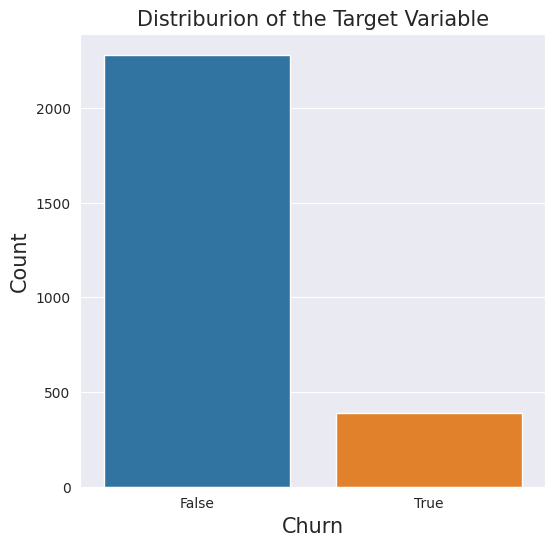

In [0]:
# Visualizing churn 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6), dpi=100)
ax = sns.countplot(x="Churn", data=df.select("*").toPandas())
ax.set_title('Distriburion of the Target Variable', fontsize=15)
ax.set_xlabel('Churn', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

In [0]:
# Convert (Churn)binary variable into numeric so plotting is easier. 
df.select("*").toPandas()['Churn'] = df.select("*").toPandas()['Churn'].map({'Yes': 1, 'No': 0})

Out[12]: Text(0.5, 1.0, 'Churn count by International plan')

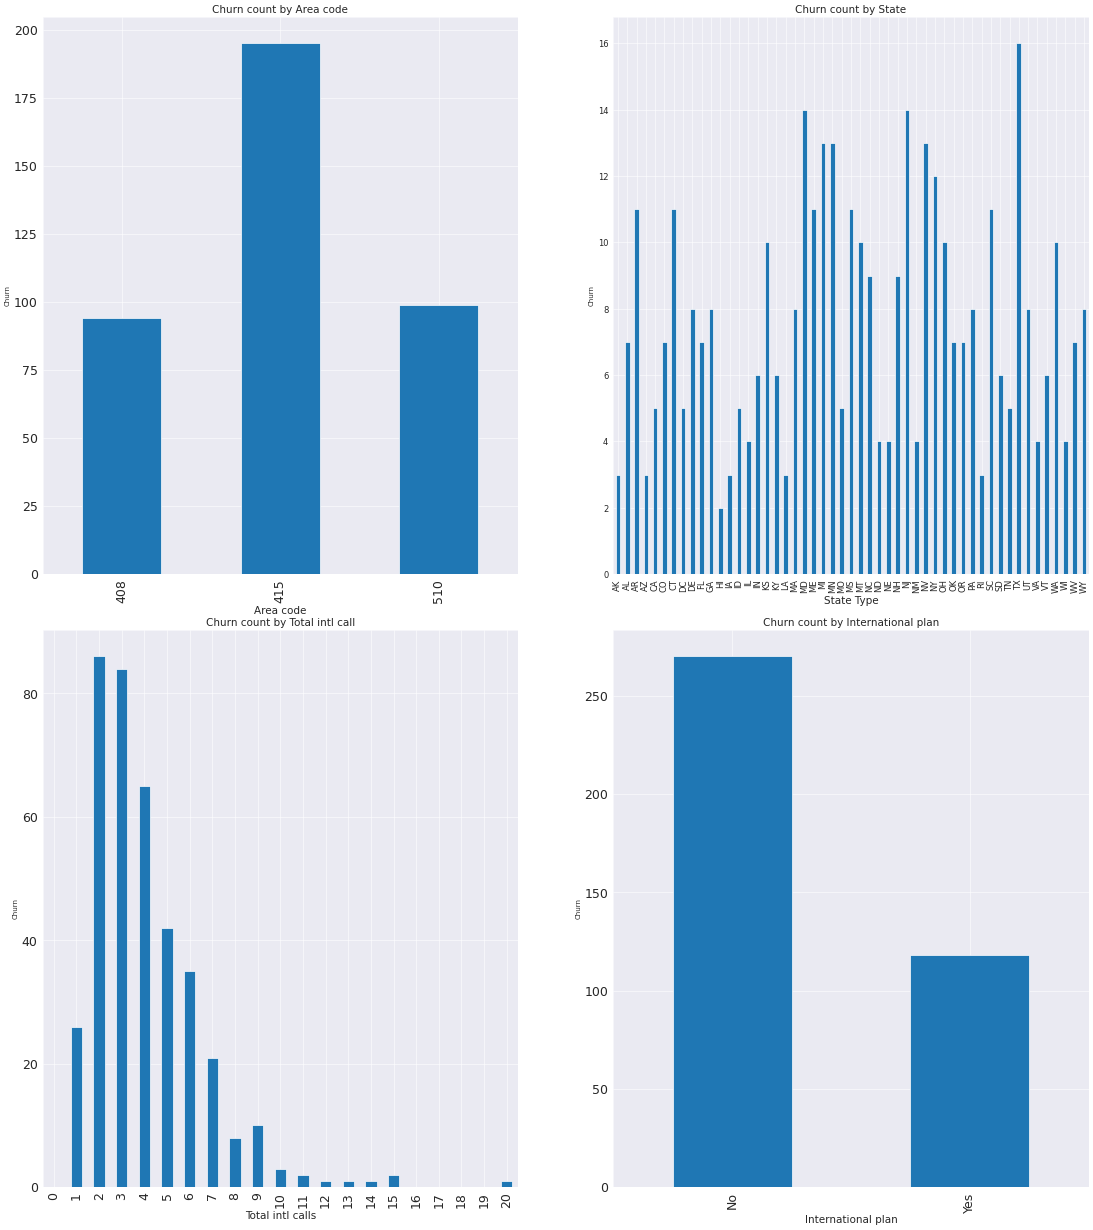

In [0]:
# Various plots of Target (Churn) with different variables. This will provide an overview of dependancy of variables with target.

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(27,31), dpi = 50)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None ,wspace=None, hspace=0.1)
plt.rc('xtick', labelsize = 12)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 12)  

df.select("*").toPandas().groupby('Area code').Churn.sum().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Churn',fontsize = 10)
ax1.set_xlabel('Area code',fontsize = 15)
ax1.tick_params(labelsize = 18)
ax1.set_title('Churn count by Area code',fontsize = 15)

df.select("*").toPandas().groupby('State').Churn.sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Churn',fontsize = 10)
ax2.set_xlabel('State Type',fontsize = 15)
ax2.tick_params(labelsize = 12)
ax2.set_title('Churn count by State',fontsize = 15)

df.select("*").toPandas().groupby('Total intl calls').Churn.sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Churn',fontsize = 10)
ax3.set_xlabel('Total intl calls',fontsize = 15)
ax3.tick_params(labelsize = 18)
ax3.set_title('Churn count by Total intl call',fontsize = 15)

df.select("*").toPandas().groupby('International plan').Churn.sum().plot(kind='bar', ax=ax4)
ax4.set_ylabel('Churn',fontsize = 10)
ax4.set_xlabel('International plan',fontsize = 15)
ax4.tick_params(labelsize = 18)
ax4.set_title('Churn count by International plan',fontsize = 15)


In [0]:
# Converting to NaN since we need to find the mean and that cannot be computed with an empty string. It can be computed using NaN

import numpy as np
df.select("*").toPandas().replace(" ", np.nan, inplace=True) 
testdf.select("*").toPandas().replace(" ", np.nan, inplace=True) 

In [0]:
df.select("*").toPandas().isna().sum()

Out[14]: State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

Out[15]: Text(9.912123842592592, 0.5, 'Total day charge')<Figure size 3200x640 with 0 Axes>

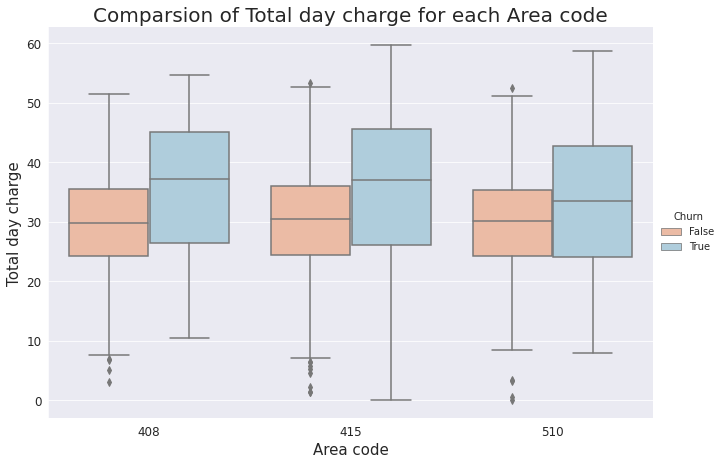

In [0]:
# Bar graph for Comparsion of Total day charge for each Area code with respect to target

plt.figure(figsize=(40,8), dpi=80)
# Sns.set(rc={'figure.figsize':(25,15)})
ax = sns.catplot(x="Area code", y="Total day charge", hue="Churn", kind="box", data=df.select("*").toPandas(), height = 6,aspect = 1.5,palette = 'RdBu')
plt.title('Comparsion of Total day charge for each Area code',fontsize = 20)
plt.xlabel('Area code',fontsize = 15)
plt.ylabel('Total day charge',fontsize = 15)

In [0]:
# Grouping Tenure data whether customers churn or not with respect to total day minutes using density plots

kde_plot_data_a = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 1]['Total day minutes']
kde_plot_data_b = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 0]['Total day minutes']

Out[17]: Text(0, 0.5, 'Kernel Density Estimate')

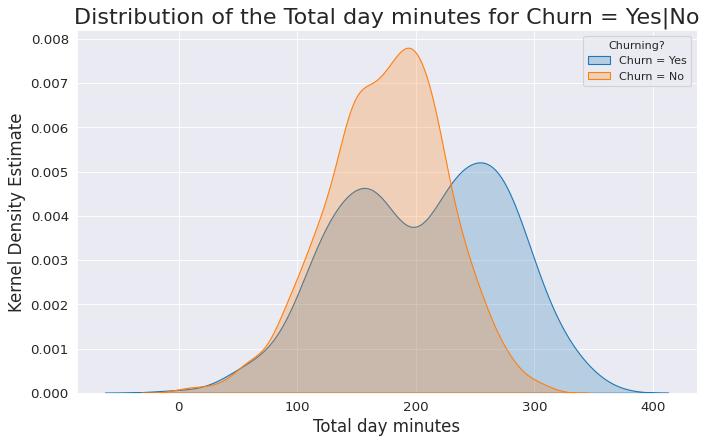

In [0]:
plt.figure(figsize=(10,6), dpi=80)
sns.kdeplot(data = kde_plot_data_a,shade = True, legend = False)
sns.kdeplot(data = kde_plot_data_b, shade = True, legend = False)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.title('Distribution of the Total day minutes for Churn = Yes|No',fontsize=20)
plt.xlabel('Total day minutes',fontsize = 15)
plt.ylabel('Kernel Density Estimate',fontsize = 15)

In [0]:
# Grouping Tenure data by whether customers churn or not with respect to total day calls

kde_plot_data_c = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 1]['Total day calls']
kde_plot_data_d = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 0]['Total day calls']

Out[19]: Text(0, 0.5, 'Kernel Density Estimate')

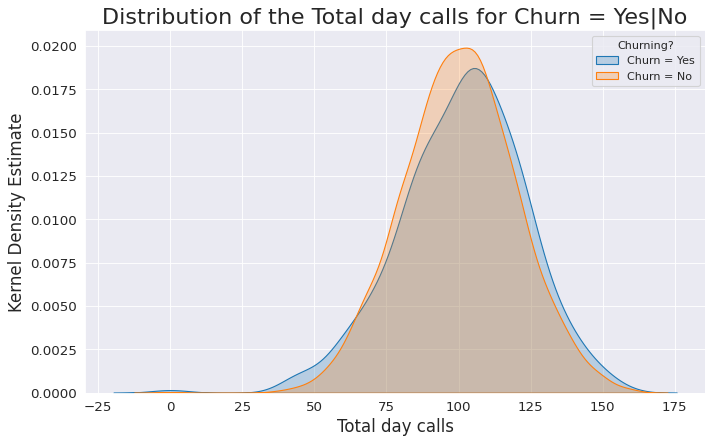

In [0]:
plt.figure(figsize=(10,6), dpi=80)
sns.kdeplot(data = kde_plot_data_c,shade = True, legend = False)
sns.kdeplot(data = kde_plot_data_d, shade = True, legend = False)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.title('Distribution of the Total day calls for Churn = Yes|No',fontsize=20)
plt.xlabel('Total day calls',fontsize = 15)
plt.ylabel('Kernel Density Estimate',fontsize = 15)

In [0]:
# Grouping Tenure data by whether customers churn or not with respect to account length

kde_plot_data_e = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 1]['Total intl charge']
kde_plot_data_f = df.select("*").toPandas()[df.select("*").toPandas()['Churn'] == 0]['Total intl charge']

Out[21]: Text(0, 0.5, 'Kernel Density Estimate')

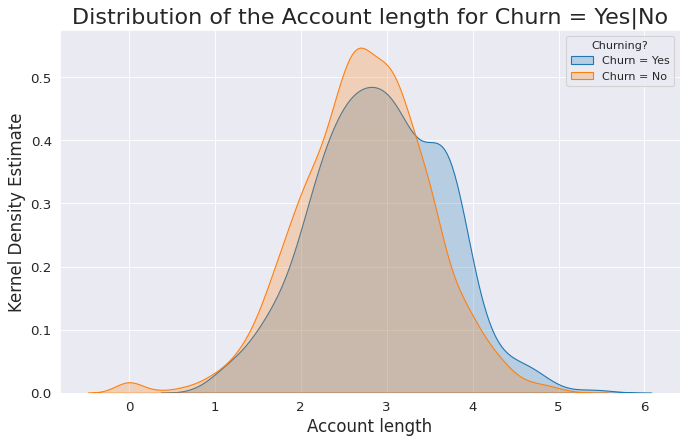

In [0]:
plt.figure(figsize=(10,6), dpi=80)
sns.kdeplot(data = kde_plot_data_e,shade = True, legend = False)
sns.kdeplot(data = kde_plot_data_f, shade = True, legend = False)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.title('Distribution of the Account length for Churn = Yes|No',fontsize=20)
plt.xlabel('Account length',fontsize = 15)
plt.ylabel('Kernel Density Estimate',fontsize = 15)

In [0]:
# Converting test data from pyspark to panda dataframe
testdf.select("*").toPandas()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,No,Yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2,False
663,AL,106,408,No,Yes,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1,False
664,VT,60,415,No,No,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3,False
665,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False


Out[23]: <AxesSubplot:>

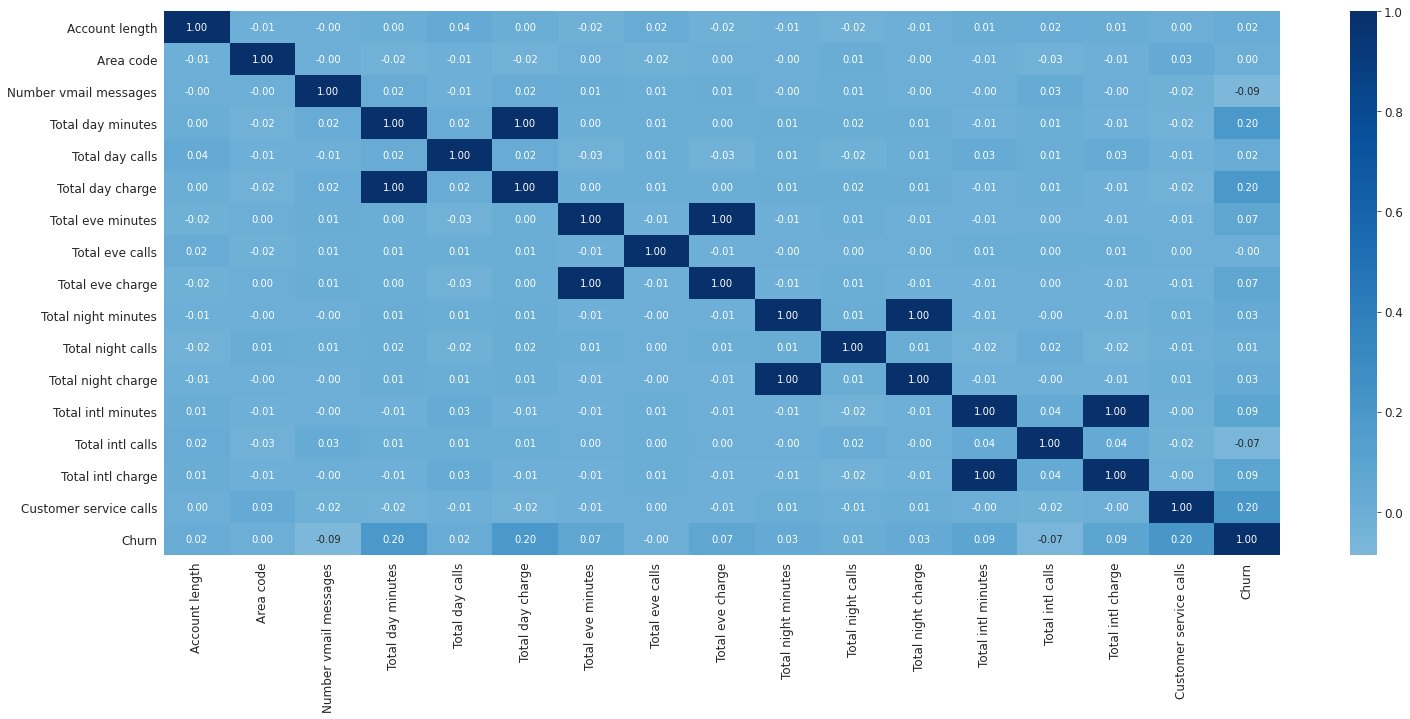

In [0]:
#Plot the heatmap to check the correlation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (25,10))
sns.heatmap(df.select("*").toPandas().corr(), cmap = 'Blues', annot = True, center=0, fmt = '.2f')
#plt.show()

In [0]:
#It can be seen that there is good correlation between Total minutes and Total charge. Therefore, it is better to drop one of the can be dropped.

In [0]:
#We transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps Yes/True and No/False to 1 and 0, respectively. All these tasks will be done using the following get_data function.

In [0]:
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df

In [0]:
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']

traindf = get_data(df, removeCols=removeCols)

In [0]:
# removing columns from test data as well 

testdf = get_data(testdf, removeCols=removeCols)

In [0]:
testdf.select("*").toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          667 non-null    int32  
 1   International plan      667 non-null    float64
 2   Voice mail plan         667 non-null    float64
 3   Number vmail messages   667 non-null    int32  
 4   Total day calls         667 non-null    int32  
 5   Total day charge        667 non-null    float64
 6   Total eve calls         667 non-null    int32  
 7   Total eve charge        667 non-null    float64
 8   Total night calls       667 non-null    int32  
 9   Total night charge      667 non-null    float64
 10  Total intl calls        667 non-null    int32  
 11  Total intl charge       667 non-null    float64
 12  Customer service calls  667 non-null    int32  
 13  Churn                   667 non-null    float64
dtypes: float64(7), int32(7)
memory usage: 54.8

In [0]:
testdf.select("*").toPandas()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Churn
0,117,0.0,0.0,0,97,31.37,80,29.89,90,9.71,4,2.35,1,0.0
1,65,0.0,0.0,0,137,21.95,83,19.42,111,9.40,6,3.43,4,1.0
2,161,0.0,0.0,0,67,56.59,97,27.01,128,7.23,9,1.46,4,1.0
3,111,0.0,0.0,0,103,18.77,102,11.67,105,8.53,6,2.08,2,0.0
4,49,0.0,0.0,0,117,20.28,109,18.28,90,8.04,1,3.00,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,0.0,1.0,26,88,23.31,125,13.23,94,11.14,7,3.11,2,0.0
663,106,0.0,1.0,29,131,14.21,131,17.33,73,10.33,3,2.19,1,0.0
664,60,0.0,0.0,0,118,32.96,110,7.23,134,9.45,8,3.56,3,0.0
665,159,0.0,0.0,0,114,28.87,105,16.80,82,8.72,4,3.13,1,0.0


In [0]:
traindf.select("*").toPandas()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve calls,Total eve charge,Total night calls,Total night charge,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,0.0,1.0,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0.0
1,107,0.0,1.0,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0.0
2,137,0.0,0.0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0.0
3,84,1.0,0.0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0.0
4,75,1.0,0.0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,79,0.0,0.0,0,98,22.90,68,16.12,128,9.96,5,3.19,2,0.0
2662,192,0.0,1.0,36,77,26.55,126,18.32,83,12.56,6,2.67,2,0.0
2663,68,0.0,0.0,0,57,39.29,55,13.04,123,8.61,4,2.59,3,0.0
2664,28,0.0,0.0,0,109,30.74,58,24.55,91,8.64,6,3.81,2,0.0


Using the Spark MLlib Package

The MLlib package provides a variety of machine learning algorithms for classification, regression, cluster and dimensionality reduction, as well as utilities for model evaluation. The decision tree is a popular classification algorithm, and we will be using extensively in this part.

Model Training

MLlib classifiers and regressors require data sets in a format of rows of type LabeledPoint, which separates row labels and feature lists, and names them accordingly. The custom labelData() function shown below performs the row parsing. We will pass it the prepared data set (CV_data) and split it further into training and testing sets. A decision tree classifier model is then generated using the training data. The tree depth can be regarded as an indicator of model complexity.
Note: you can't map a dataframe, but you can convert the dataframe to an RDD and map that by doing data.rdd.map().

In [0]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
     #label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(traindf).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                      maxBins=32, impurity='gini')
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(0.0, [128.0,0.0,1.0,25.0,110.0,45.07,99.0,16.78,91.0,11.01,3.0,2.7,1.0]), LabeledPoint(0.0, [107.0,0.0,1.0,26.0,123.0,27.47,103.0,16.62,103.0,11.45,3.0,3.7,1.0])]
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 12 <= 3.5)
   If (feature 5 <= 44.545)
    Predict: 0.0
   Else (feature 5 > 44.545)
    Predict: 1.0
  Else (feature 12 > 3.5)
   If (feature 5 <= 29.03)
    Predict: 1.0
   Else (feature 5 > 29.03)
    Predict: 0.0



In [0]:
#The toDebugString() function provides a print of the tree's decision nodes and final prediction outcomes at the end leafs. We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn. It's not surprising that these feature numbers map to the fields Customer service calls and Total day minutes. Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

Model Evaluation

Firstly let’s expose a brief state of art about the Spark MLlib and ML functions that used to compute these metrics:
MulticlassMetrics: from this function, it is possible to compute the confusion matrix, precision per class, weighted precision, recall per class, weighted recall, fmesure or score per class, weighted fmesure and accuracy.
BinaryClassificationEvaluator: with this function, it is possible to compute two metrics which are the area under ROC and the area under PR.
MulticlassClassificationEvaluator: according to this function, it is able to compute f1, weighted precision, weighted recall and accuracy.
Due to the conflict that can be conducted by studying the different metrics, I will define in this subsection a printAllMetrics function in which I well explained how to compute the more known binary classification metrics.
Note:
The new defined function needs a dataframe as input with essentially two required columns which are the target or label and the predicted label.
We have preceded some metrics by two stars (**) because they are the useful ones that are genarally used for the analysis

In [0]:
def printAllMetrics(predictionsDF):
    TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
    FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
    TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
    FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

    precision_p   = TP/(TP+FP)
    precision_n   = TN/(TN+FN)
    recall_p      = TP/(TP+FN)
    recall_n      = TN/(TN+FP)
    f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
    f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
    avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
    avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
    avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
    accuracy      = (TN+TP)/(TP+FN+TN+FP)

    print('Precision of True    ', precision_p)
    print('Precision of False   ', precision_n)
    print('** Avg Precision     ', avg_precision)
    print('Recall of True       ', recall_p)
    print('Recall of False      ', recall_n)
    print('** Avg Recall        ', avg_recall)
    print('F1 of True           ', f1_p)
    print('F1 of False          ', f1_n)
    print('** Avg F1            ', avg_f1)
    print('** Accuracy          ', accuracy)

In [0]:
#Predictions of the testing data's churn outcome are made with the model's predict function and grouped together with the actual churn label of each customer data using getPredictionsLabels function.
#The MLlib's RandomForest will be used for the model evaluation by taking rows of (prediction, label) tuples as input. It provides its metrics which have been bundled for printing with the custom printMetrics function.

In [0]:
from pyspark.mllib.tree import RandomForest
from time import *

RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 16
RF_MAX_BINS = 227612
start_time = time()

model = RandomForest.trainClassifier(training_data, 
                                     numClasses=2,
                                     categoricalFeaturesInfo={}, \
                                     numTrees=RF_NUM_TREES, featureSubsetStrategy="auto", impurity="gini", \
                                     maxDepth=RF_MAX_DEPTH, maxBins=RF_MAX_BINS, seed=45)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

predictions = model.predict(testing_data.map(lambda x: x.features))
labels_and_predictions = testing_data.map(lambda x: x.label).zip(predictions)
acc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())
print("Model precision: %.3f%%" % (acc * 100))
# model.save(sc, 'dbfs:/FileStore/RandomForestModel/')

Time to train model: 2.611 seconds
Model precision: 85.987%


In [0]:
# Predictions of the testing data's churn outcome are made with the model's predict function and grouped together with the actual churn label of each customer data using getPredictionsLabels function.
#The MLlib's MulticlassMetrics will be used for the model evaluation by taking rows of (prediction, label) tuples as input. It provides its metrics which have been bundled for printing with the custom printMetrics function.

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, testing_data):
    predictions = model.predict(testing_data.map(lambda r: r.features))
    return predictions.zip(testing_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall) 
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix
 [[372.  15.]
 [ 51.  33.]]
Precision of True     0.6875
Precision of False    0.8794326241134752
Weighted Precision    0.8452026019785879
Recall of True        0.39285714285714285
Recall of False       0.9612403100775194
Weighted Recall       0.8598726114649682
FMeasure of True      0.5
FMeasure of False     0.9185185185185185
Weighted fMeasure     0.8438782731776362
Accuracy              0.8598726114649682


In [0]:
#To check the above obtained results and comparing them with those that will be obtained using our new printAllMetrics function, let's displaying the confusion matrix that is used to compute all the variables of our new function:

In [0]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   33|
|  0.0|           1.0|   15|
|  1.0|           0.0|   51|
|  0.0|           0.0|  372|
+-----+--------------+-----+

Precision of True     0.6875
Precision of False    0.8794326241134752
** Avg Precision      0.8452026019785879
Recall of True        0.39285714285714285
Recall of False       0.9612403100775194
** Avg Recall         0.8598726114649682
F1 of True            0.5
F1 of False           0.9185185185185185
** Avg F1             0.8438782731776362
** Accuracy           0.8598726114649682


As can be seen above, the FMesure given by the MulticlassMetrics is none other than the known classical F1 metric. All the metrics given by the printAllMetrics are correctly defined. Noting that the word Weighted is equivalent to Average.

The overall Accuracy, seems quite good, but one troubling issue is the discrepancy between the recall measures. The recall (aka sensitivity) for the Churn=False samples is high, while the recall for the Churn=True examples is relatively low. Business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, we need to ensure that our model is sensitive to the Churn=True samples.
Perhaps the model's sensitivity bias toward Churn=False samples is due to a skewed distribution of the two types of samples. Let's try grouping the CV_data DataFrame by the Churn field and counting the number of instances in each group.

In [0]:
traindf.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0| 2278|
|  1.0|  388|
+-----+-----+



In [0]:
#Stratified Sampling

Stratified Sampling
There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames sampleBy() function does this when provided with fractions of each sample type to be returned.

Here we're keeping all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 388/2278.

In [0]:
stratified_CV_data = traindf.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,397
1,1.0,388


In [0]:
#Let's build a new model using the evenly distributed data set and see how it performs.

In [0]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Confusion Matrix
 [[72.  8.]
 [39. 43.]]
Precision of True     0.8431372549019608
Precision of False    0.6486486486486487
Weighted Precision    0.7470934987274856
Recall of True        0.524390243902439
Recall of False       0.9
Weighted Recall       0.7098765432098766
FMeasure of True      0.6466165413533834
FMeasure of False     0.7539267015706806
Weighted fMeasure     0.699609213065629
Accuracy              0.7098765432098766


In [0]:
#With these new recall values, we can see that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.

Spark ML Package

The ML package is the newer library of machine learning routines. It provides an API for pipelining data transformers, estimators and model selectors. It will be used here to perform cross-validation across several classifiers in order to find the optimal model.
Pipelining
The ML package needs data be put in a (label: Double, features: Vector) DataFrame format with correspondingly named fields using the VectorAssembler function. The global get_dummy function defined below performs this formatting in which we will also pass the data through a pipeline of two transformers, StringIndexer and VectorIndexer which index the label and features fields respectively.
Model Selection
Given the data set at hand, we would like to determine which parameter values of or classifier produce the best model. We need a systematic approach to quantatively measure the performance of the models and ensure that the results are reliable. This task of model selection is often done using cross validation techniques. A common technique is k-fold cross validation, where the data is randomly split into k partitions. Each partition is used once as the testing data set, while the rest are used for training. Models are then generated using the training sets and evaluated with the testing sets, resulting in k model performance measurements. The average of the performance scores is often taken to be the overall score of the model, given its build parameters.
For model selection, we can search through the model parameters, comparing their cross validation performances. The model parameters leading to the highest performance metric produce the best model.
The ML package supports k-fold cross validation, which can be readily coupled with a parameter grid builder and an evaluator to construct a model selection workflow. Below, we will use a transformation/estimation pipeline to train our classifier models. The cross validator will use in this example an empty ParamGridBuilder to iterate through the default parameters of the studied classifiers and evaluate their models using the F1 score, repeating 3 times per default parameter value for reliable results.

In [0]:
# We define a get_dummy function that transforms a given classical dataframe to a new other one composed of dense vectors reliable to be running with Spark ML.

In [0]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')

    # Automatically identify categorical features and index them
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

    pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

    model = pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(labelCol))

    return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

In [0]:
#Once the required function is ready, let's define the needed numericCols list by removing the Churn column and transforming the datasets:

In [0]:
numericCols = stratified_CV_data.columns
numericCols.remove("Churn")

vectorized_CV_data = get_dummy(traindf, numericCols, "Churn")
vectorized_stratified_CV_data = get_dummy(stratified_CV_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(testdf, numericCols, "Churn")

In [0]:
#Let's now looking the structure of one of the transformed datasets to see what has been happened by comparing it to the structure displayed above:

In [0]:
vectorized_stratified_CV_data.show(2, False)

+--------------------------------------------------------------------+-----+--------------------------------------------------------------------+------------+
|features                                                            |label|indexedFeatures                                                     |indexedLabel|
+--------------------------------------------------------------------+-----+--------------------------------------------------------------------+------------+
|[107.0,0.0,1.0,26.0,123.0,27.47,103.0,16.62,103.0,11.45,3.0,3.7,1.0]|0.0  |[107.0,0.0,1.0,26.0,123.0,27.47,103.0,16.62,103.0,11.45,3.0,3.7,1.0]|0.0         |
|[141.0,1.0,1.0,37.0,84.0,43.96,111.0,18.87,97.0,14.69,5.0,3.02,0.0] |0.0  |[141.0,1.0,1.0,37.0,84.0,43.96,111.0,18.87,97.0,14.69,5.0,3.02,0.0] |0.0         |
+--------------------------------------------------------------------+-----+--------------------------------------------------------------------+------------+
only showing top 2 rows



K-fold cross validation: We will define below a cvComparing function in order to compute the cross validation procedures and keeping all the necessary metrics during the training as well as the test steps. In order to make the results more readable, I rounded the metrics by specifying the number of decimal places.

In [0]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
    names = []
    underROC_train = []
    underROC_test = []
    f1_train = []
    f1_test = []
    wp_train = []
    wp_test = []
    wr_train = []
    wr_test = []
    acc_train = []
    acc_test = []

    evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")

    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
    evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 

    for name, clf in classifiers:
        cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
        cvModel = cv.fit(vectorized_train_data)  
        predict_train = cvModel.transform(vectorized_train_data)
        predict_test = cvModel.transform(vectorized_test_data)
        underROC_train.append(evaluatorB.evaluate(predict_train))
        underROC_test.append(evaluatorB.evaluate(predict_test))
        f1_train.append(evaluatoracc.evaluate(predict_train))
        f1_test.append(evaluatoracc.evaluate(predict_test))
        wp_train.append(evaluatorwp.evaluate(predict_train))
        wp_test.append(evaluatorwp.evaluate(predict_test))
        wr_train.append(evaluatorwr.evaluate(predict_train))
        wr_test.append(evaluatorwr.evaluate(predict_test))
        acc_train.append(evaluatoracc.evaluate(predict_train))
        acc_test.append(evaluatoracc.evaluate(predict_test))
        names.append(name)

    cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test), 
                                       schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])
  
    for t in cvResults.dtypes:
        if t[1] == 'double':
            cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))
  
    return cvResults

In [0]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


cvResults_CV_data = cvComparing(vectorized_train_data=vectorized_CV_data, vectorized_test_data=vectorized_final_test_data, 
                                classifiers=classifiers, paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data=vectorized_stratified_CV_data, 
                                           vectorized_test_data=vectorized_final_test_data, classifiers=classifiers, 
                                           paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

In [0]:
#Model Evaluation

# The actual performance of the models is determined based on both CV_data and stratified_CV_data as well as final_test_data sets. The last one has not been used for any training or cross validation activities. We will transform the test set with the model pipeline, which will map the labels and features according to the same recipe. The evaluators will provide us all the metrics of the MulticlassClassificationEvaluator function as well as the Area Under ROC (underRoc) metric based on the BinaryClassificationEvaluator obtained from the predictions during the training and the test steps. These metrics are computed using the above studied classifiers with its default parameters accross 5-fold cross validation by trying to find the best value of the F1 metric.

In [0]:
#Metrics computed using all the data of CV_data for the training step:

In [0]:
cvResults_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.597,0.577,0.863,0.855,0.863,0.855,0.835,0.820,0.863,0.855
NB,0.621,0.620,0.503,0.499,0.503,0.499,0.820,0.823,0.503,0.499
SVC,0.500,0.500,0.854,0.858,0.854,0.858,0.730,0.735,0.854,0.858
DT,0.841,0.818,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945
RF,0.796,0.744,0.940,0.922,0.940,0.922,0.944,0.922,0.940,0.922
GBT,0.921,0.859,0.976,0.954,0.976,0.954,0.976,0.953,0.976,0.954


In [0]:
cvResults_CV_data.toPandas().transpose()

,0,1,2,3,4,5
Classifier name,LR,NB,SVC,DT,RF,GBT
underROC_train,0.597,0.621,0.5,0.841,0.796,0.921
underROC_test,0.577,0.62,0.5,0.818,0.744,0.859
Accuracy_train,0.863,0.503,0.854,0.948,0.94,0.976
Accuracy_test,0.855,0.499,0.858,0.945,0.922,0.954
f1_train,0.863,0.503,0.854,0.948,0.94,0.976
f1_test,0.855,0.499,0.858,0.945,0.922,0.954
wPrecision_train,0.835,0.82,0.73,0.948,0.944,0.976
wPrecision_test,0.82,0.823,0.735,0.945,0.922,0.953
wRecall_train,0.863,0.503,0.854,0.948,0.94,0.976


In [0]:
display(cvResults_CV_data)

Classifier name,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
LR,0.597,0.577,0.863,0.855,0.863,0.855,0.835,0.82,0.863,0.855
NB,0.621,0.62,0.503,0.499,0.503,0.499,0.82,0.823,0.503,0.499
SVC,0.5,0.5,0.854,0.858,0.854,0.858,0.73,0.735,0.854,0.858
DT,0.841,0.818,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945
RF,0.796,0.744,0.94,0.922,0.94,0.922,0.944,0.922,0.94,0.922
GBT,0.921,0.859,0.976,0.954,0.976,0.954,0.976,0.953,0.976,0.954


In [0]:
cvResults_stratified_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.764,0.752,0.764,0.763,0.764,0.763,0.764,0.860,0.764,0.763
NB,0.595,0.610,0.592,0.481,0.592,0.481,0.613,0.820,0.592,0.481
SVC,0.759,0.760,0.759,0.769,0.759,0.769,0.759,0.864,0.759,0.769
DT,0.905,0.862,0.906,0.898,0.906,0.898,0.909,0.915,0.906,0.898
RF,0.900,0.852,0.901,0.859,0.901,0.859,0.904,0.904,0.901,0.859
GBT,0.938,0.870,0.939,0.913,0.939,0.913,0.943,0.923,0.939,0.913


In [0]:
cvResults_stratified_CV_data.toPandas().transpose()
display(cvResults_stratified_CV_data)

Classifier name,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
LR,0.764,0.752,0.764,0.763,0.764,0.763,0.764,0.86,0.764,0.763
NB,0.595,0.61,0.592,0.481,0.592,0.481,0.613,0.82,0.592,0.481
SVC,0.759,0.76,0.759,0.769,0.759,0.769,0.759,0.864,0.759,0.769
DT,0.905,0.862,0.906,0.898,0.906,0.898,0.909,0.915,0.906,0.898
RF,0.9,0.852,0.901,0.859,0.901,0.859,0.904,0.904,0.901,0.859
GBT,0.938,0.87,0.939,0.913,0.939,0.913,0.943,0.923,0.939,0.913


According to the above two plots, we cannot confirm that the data stratification is a good idea that can improve the learning. The metrics computed using all the data are higher than those obtained with the stratified data. This implies that the stratified data are poorly and cannot goodly cover all the situations present in global data. It is clear that the Decision tree, Random forest and Gradient-boosted tree are the more efficient classifiers. However, it seems that the Decision tree is the best classifier because all its metrics are close to each other for the two situations of data.

In [0]:
#Comparison of the metric values given by the printAllMetrics function with those obtained using MulticlassClassificationEvaluator:
#To achieve such a comparison, let's using one of the above studied classifier and computing the required metrics based on the two functions:

In [0]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1") 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision") 
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall") 
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy") 


clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
#clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_final_test_data)  
pred_train = clfModel.transform(vectorized_final_test_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))


print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))



Weighted Precision    0.9481354112750475
Weighted Recall       0.9460269865067467
F1                    0.9409242094376606
Accuracy              0.9460269865067467
Precision of True     0.9836065573770492
Precision of False    0.9422442244224423
** Avg Precision      0.9481354112750474
Recall of True        0.631578947368421
Recall of False       0.9982517482517482
** Avg Recall         0.9460269865067467
F1 of True            0.7692307692307693
F1 of False           0.969439728353141
** Avg F1             0.9409242094376606
** Accuracy           0.9460269865067467


In [0]:
#All the metrics given by the new printAllMetrics function are correctly running. The four metrics such as Avg Precision, Avg Recall, Avg F1 and Accuracy are exactly the same as those given by the MulticlassClassificationEvaluator function. It is noticed that the term Weighted has the sense of Average. F1 computed with MulticlassClassificationEvaluator is none other than the Avg F1 calculated with the printAllMetrics function or the Weighted FMeasure computed using the MulticlassMetrics function.

Conclusion:
    
The Decision tree, Random forest and Gradient-boosted tree are the more efficient classifiers. However, the best model created according to the cross validation process seems to be the Decision tree. Indeed, the different metrics obtained by using this classifier are higher as well as very close to each other comparing to those of the other classifiers. An explication on how to compute all the different metrics excepting both area under ROC and area under PR is given in a function called printAllMetrics.
Other improvements are still to be expected very soon as a prediction based on cross validation applying the ParamGridBuilder to iterate through required parameters according to each classifier.